In [1]:
# !git clone https://github.com/matterport/Mask_RCNN.git

In [2]:
import os
os.chdir("Mask_RCNN/samples")

In [3]:
# %tensorflow_version 1.x
# import tensorflow
# print(tensorflow.__version__)
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior() 
!pip3 install keras==2.2.5
!pip install tensorflow==1.15.0rc2
# !pip install Keras==2.3.1 tensorflow==2.1.0

     |████████████████████████████████| 412.3MB 41kB/s 
     |████████████████████████████████| 512kB 50.7MB/s 
     |████████████████████████████████| 3.8MB 29.1MB/s 
  Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:
      Successfully uninstalled tensorflow-estimator-2.1.0
  Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
  Found existing installation: tensorflow 2.1.0
    Uninstalling tensorflow-2.1.0:
      Successfully uninstalled tensorflow-2.1.0


In [4]:
# COCO related libraries
import sys
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR) 
# MaskRCNN libraries
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco


# Misc
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

Using TensorFlow backend.


In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:

# Number of classes in dataset. Must be of type integer
NUM_CLASSES = 3

# Relative path to .h5 weights file
WEIGHTS_FILE = None

# Relative path to annotations JSON file
TRAIN_ANNOTATIONS_FILE = os.path.abspath("../../drive/MyDrive/MRCNN model weights/Dataset/Train/ann/train.json")

# Relative path to directory of images that pertain to annotations file
TRAIN_ANNOTATION_IMAGE_DIR = os.path.abspath("../../drive/MyDrive/MRCNN model weights/Dataset/Train/img")

# Relative path to annotations JSON file
VALIDATION_ANNOTATIONS_FILE = os.path.abspath("../../drive/MyDrive/MRCNN model weights/Dataset/Val/ann/Val.json")

# Relative path to directory of images that pertain to annotations file
VALIDATION_ANNOTATION_IMAGE_DIR = os.path.abspath("../../drive/MyDrive/MRCNN model weights/Dataset/Val/img")

# Number of epochs to train dataset on
NUM_EPOCHS = 10

MODEL_NAME = "model_2"

In [7]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [29]:


class TrainConfig(coco.CocoConfig):
    """
    """
    # Give the configuration a recognizable name
    NAME = MODEL_NAME

    # Train on 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1

    # Min and max image dimensions
    # IMAGE_MIN_DIM = 1152
    # IMAGE_MAX_DIM = 1280

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 50

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 50
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet101'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    
    # Changed to 512 because that's how many the original MaskRCNN paper used
    TRAIN_ROIS_PER_IMAGE = 200
    MAX_GT_INSTANCES = 114
    POST_NMS_ROIS_INFERENCE = 1000 
    POST_NMS_ROIS_TRAINING = 2000 
    
    DETECTION_MAX_INSTANCES = 114
    DETECTION_MIN_CONFIDENCE = 0.1

In [30]:
TrainConfig().display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        114
DETECTION_MIN_CONFIDENCE       0.1
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [32]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [33]:
dataset_train = CocoLikeDataset()
dataset_train.load_data(TRAIN_ANNOTATIONS_FILE, TRAIN_ANNOTATION_IMAGE_DIR)
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data(VALIDATION_ANNOTATIONS_FILE, VALIDATION_ANNOTATION_IMAGE_DIR)
dataset_val.prepare()

In [34]:
model = modellib.MaskRCNN(mode = "training", config = TrainConfig(), model_dir = MODEL_DIR)

In [35]:
if WEIGHTS_FILE is not None:
    model.load_weights(WEIGHTS_FILE, by_name = True)

In [36]:
start_train = time.time()
model.train(dataset_train, dataset_val, learning_rate = TrainConfig().LEARNING_RATE, epochs = NUM_EPOCHS, layers = 'all')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN/logs/model_220210112T0612/mask_rcnn_model_2_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 1/10
50/50 [==============================] - 174s 3s/step - loss: 9.9375 - rpn_class_loss: 0.8718 - rpn_bbox_loss: 5.3262 - mrcnn_class_loss: 0.7909 - mrcnn_bbox_loss: 2.5231 - mrcnn_mask_loss: 0.4254 - val_loss: 6.7394 - val_rpn_class_loss: 1.3104 - val_rpn_bbox_loss: 3.2746 - val_mrcnn_class_loss: 0.2226 - val_mrcnn_bbox_loss: 1.3431 - val_mrcnn_mask_loss: 0.5886
Epoch 2/10
50/50 [==============================] - 53s 1s/step - loss: 3.0327 - rpn_class_loss: 0.1930 - rpn_bbox_loss: 1.1256 - mrcnn_class_loss: 0.2862 - mrcnn_bbox_loss: 0.8587 - mrcnn_mask_loss: 0.5691 - val_loss: 4.7871 - val_rpn_class_loss: 0.7027 - val_rpn_bbox_loss: 2.4194 - val_mrcnn_class_loss: 0.3866 - val_mrcnn_bbox_loss: 0.7258 - val_mrcnn_mask_loss: 0.5525
Epoch 3/10
50/50 [==============================] - 56s 1s/step - loss: 1.9696 - rpn_class_loss: 0.0761 - rpn_bbox_loss: 0.6127 - mrcnn_class_loss: 0.2813 - mrcnn_bbox_loss: 0.4661 - mrcnn_mask_loss: 0.5335 - val_loss: 4.3661 - val_rpn_class_loss: 0.6

In [38]:

# COCO related libraries
import coco
from pycocotools.coco import COCO

# MaskRCNN libraries
from mrcnn import utils, visualize
from mrcnn import model as modellib

# Misc
import os
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io
import random
import json
%matplotlib inline

In [39]:
# Number of classes in dataset. Must be of type integer
NUM_CLASSES = 3

# Relative path to .h5 weights file
WEIGHTS_FILE = None

# Relative path to annotations JSON file
ANNOTATIONS_FILE = os.path.abspath("../../drive/MyDrive/MRCNN model weights/Dataset/Train/ann/train.json")

# Relative path to directory of images that pertain to annotations file
ANNOTATION_IMAGE_DIR = os.path.abspath("../../drive/MyDrive/MRCNN model weights/Dataset/Train/img")

# Relative path to the directory of images that you want to run inferencing on
TEST_IMAGE_DIR = os.path.abspath("../../drive/MyDrive/MRCNN model weights/Dataset/Dataset")

MODEL_NAME = "model_2"

In [40]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [41]:
class InferenceConfig(coco.CocoConfig):
    # Train on 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    # GPU COUNT is modified so that its actually the id of the GPU you want to use. For example, to use the 4th GPU
    # put 3 for GPU count (0 index)
    NAME = MODEL_NAME
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1

    # All of our training images are 300x300
    # IMAGE_MIN_DIM = 1152
    # IMAGE_MAX_DIM = 1280
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet101'

    # RPN Anchor Scales
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    
    # Changed to 512 because that's how many the original MaskRCNN paper used
    TRAIN_ROIS_PER_IMAGE = 200
    MAX_GT_INSTANCES = 114
    POST_NMS_ROIS_INFERENCE = 1000 
    POST_NMS_ROIS_TRAINING = 2000 
    
    DETECTION_MAX_INSTANCES = 114
    DETECTION_MIN_CONFIDENCE = 0.1

In [42]:

InferenceConfig().display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        114
DETECTION_MIN_CONFIDENCE       0.1
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [43]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [51]:
coco_dataset = CocoLikeDataset()
coco_dataset.load_data(ANNOTATIONS_FILE, ANNOTATION_IMAGE_DIR)
coco_dataset.prepare()
class_names = ["BG","Brick Kiln","Brick Kilns"]


In [52]:
model = modellib.MaskRCNN(mode = "inference", model_dir = MODEL_DIR, config = InferenceConfig())

In [53]:
if WEIGHTS_FILE is None:
  model.load_weights(model.find_last(), by_name = True)
else: 
  model.load_weights(WEIGHTS_FILE, by_name = True)

Re-starting from epoch 10


Processing 1 images
image                    shape: (888, 1076, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1076.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


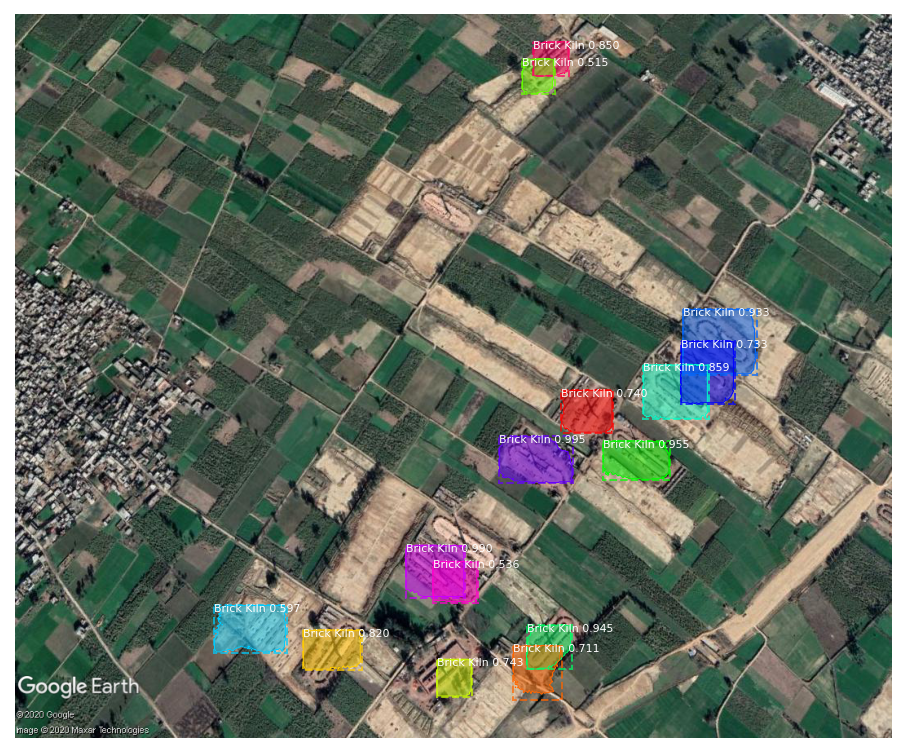

In [58]:
# Load a random image from the images folder
file_names = next(os.walk(TEST_IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(TEST_IMAGE_DIR,'training14.jpg' ))






# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])